## Imports

In [4]:
from pathlib import Path
import json
import math
import tempfile, os, sys
import time
from contextlib import contextmanager
import logging
import random
import argparse
import shutil
from collections import Counter, defaultdict
import hashlib
import logging
from dataclasses import dataclass
from typing import List
import string
from joblib import Parallel, delayed
import pickle
from collections import namedtuple
from functools import lru_cache, partial
import threading
import queue

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import ffmpeg
from scipy import stats
from scipy import ndimage as ndi
from PIL import Image, ImageDraw, FontFile, ImageFont
from IPython.display import display
import scipy.signal as sps
from typing import List
import skimage as sk
import cv2

## Utilities

In [5]:
def get_images(root=None):
    """Returns all images in order in a `root` directory"""
    if root is None:
        return [Image.open(p) for p in sorted(Path('first_video').glob('*.png'))]
    else:
        return [Image.open(p) for p in sorted(Path(root).glob('*.png'))]

def video_to_frames(video_path):
    """
    Given a valid video at `video_path`, convert each frame to a separate lossless PNG file, and return
    a PIL handle to each file. Each video result is cached to disk, allowing for subsequent invocations on the 
    same video file to take fractions of a second.
    """
    video_hash = str(hashlib.md5(open(video_path,'rb').read()).hexdigest())
    tmp = Path(f'store/ffmpeg_cache/{video_hash}')
    if tmp.exists():
        print(f"Found {video_path } cached at {tmp}")
    else:
        print(f"Caching {video_path} frames at {tmp}...")
        tmp.mkdir(parents=True)
        (
            ffmpeg
            .input(video_path)
            .output(str(tmp / '%06d.png'))
            .run()
        )
    
    images = get_images(tmp)
    
    return images

def pattern_to_video(pat, vid, fps=20):
    """
    Given a file pattern, like 'store/results/000000/tmp_frames/*.jpg`
    Uses FFMPEG to assemble all the frames as a single video, at `vid` location.
    """
    vid = Path(vid)
    vid.parent.mkdir(exist_ok=True, parents=True)
    (
        ffmpeg
        .input(str(pat), pattern_type='glob', framerate=fps)
        .output(str(vid), b="5000k")
        .run(overwrite_output=True)
    )
    return vid

class NumpyEncoder(json.JSONEncoder):
    """Used to-JSON saving, as numpy arrays are not JSON serializable out-of-the-box"""
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj,np.bool_):
            return bool(obj)
        return json.JSONEncoder.default(self, obj)
    
    
@dataclass
class Marker:
    """
    Holds all important marker data in one place
    """
    seg: np.ndarray = None
    angle: int = None
    center: np.ndarray = None
    seg_id: int = None
    obb: np.ndarray = None
    symbol_seg: List = None
    id: List = None
    text: str = 'NOTXT'
    bbox: np.ndarray = None
    

def np_load_if_exists(f):
    if f.exists():
        return np.load(f)
    else:
        return None

def write_text(text, pos, arr, font = None, fill=(0, 0, 0, 128)):
    """Write `text` on given image `arr` at position `pos`"""
    arr = sk.util.img_as_ubyte(arr)
    im = Image.fromarray(arr)
    d = ImageDraw.Draw(im)
    d.text(pos[::-1], text, font=font, fill=fill)
    arr = np.array(im)
    return arr

100%|██████████| 10/10 [00:00<00:00, 122.91it/s]


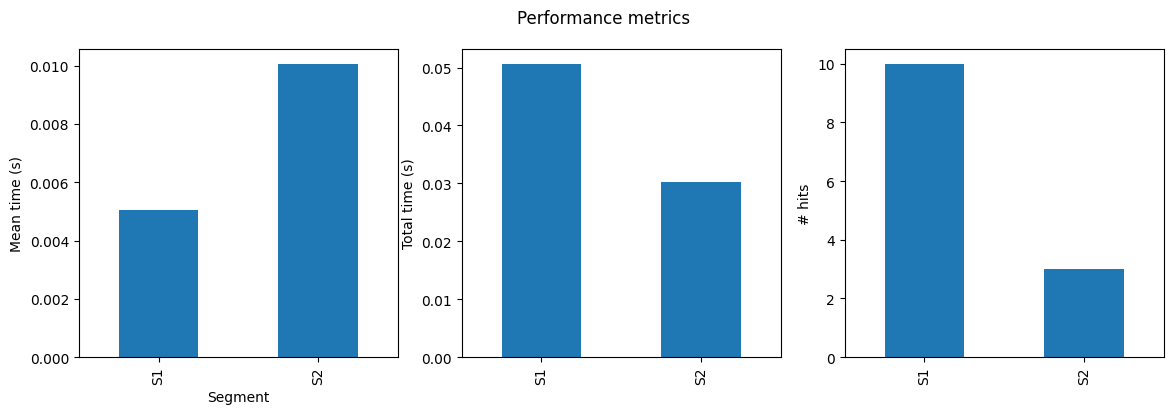

In [6]:
def mkdir(p):
    Path(p).mkdir(exist_ok=True,parents=True)
    return p

def get_logger():
    # set up logging to file
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                        datefmt='%m-%d %H:%M',
                        filename='progress.log',
                        filemode='a')
    # define a Handler which writes INFO messages or higher to the sys.stderr
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)
    # set a format which is simpler for console use
    formatter = logging.Formatter('%(name)-12s: %(levelname)-8s %(message)s')
    # tell the handler to use this format
    console.setFormatter(formatter)
    # add the handler to the root logger
    logging.getLogger('').addHandler(console)
    log = logging.getLogger('')
    # log.debug('Quick zephyrs blow, vexing daft Jim.')
    # log.info('How quickly daft jumping zebras vex.')
    # log.warning('Jail zesty vixen who grabbed pay from quack.')
    # log.error('The five boxing wizards jump quickly.')
    return log

@lru_cache
def warn_once(logger, msg: str):
    logger.warning(msg)

class CatchTime:
    """
    This class allows for convenient performance measurement. 
    It can be used as a context manager, and will plot performance metrics, like so:
    ```
    catch_time = CatchTime()
    for i in tqdm(range(10)):
        with catch_time.time("S1"):
            time.sleep(.005)
        if random.randint(0,1):
            with catch_time.time("S2"):
                time.sleep(.01)
    catch_time.plot()
    ```
    """
    def __init__(self):
        self.counts = defaultdict(list)
    @contextmanager
    def time(self, name):
        start = time.perf_counter()
        yield
        result = time.perf_counter() - start
        self.counts[name].append(result)
    
    def plot(self):
        c = pd.DataFrame({k:pd.Series(v) for k,v in self.counts.items()})
        plt.figure(figsize=(14,4))
        plt.suptitle('Performance metrics')
        plt.subplot(131)
        c.mean().plot.bar()
        plt.ylabel('Mean time (s)')
        plt.xlabel('Segment')
        plt.subplot(132)
        c.sum().plot.bar()
        plt.ylabel('Total time (s)')
        plt.subplot(133)
        c.notna().sum().plot.bar()
        plt.ylabel('# hits')
        
# Test it out
# logger = get_logger()
catch_time = CatchTime()
for i in tqdm(range(10)):
    with catch_time.time("S1"):
        time.sleep(.005)
    if random.randint(0,1):
        with catch_time.time("S2"):
            time.sleep(.01)
catch_time.plot()

In [7]:
def show(x, figsize=None):
    """
    Shows 2D image
    """
    if figsize:
        plt.figure(figsize=(figsize,figsize))
    plt.imshow(x)
    plt.show()
    
def imhist(x, bins=255, dens=True):
    """
    Show image pixel intensity distribution
    """
    plt.hist(x.ravel(), bins=bins, density=dens)
    plt.show()
    
    
def compare_n(*ims,figsize=12, title=None, show=True):
    """
    Plots N images in a single row.
    """
    f,axs = plt.subplots(ncols=len(ims), figsize=(figsize * len(ims),figsize))
    for i,im in enumerate(ims):
        if isinstance(title, str):
            axs[i].set_title(title)
        elif isinstance(title, list):
            axs[i].set_title(title[i])
        axs[i].imshow(im)
    if show:
        plt.show()

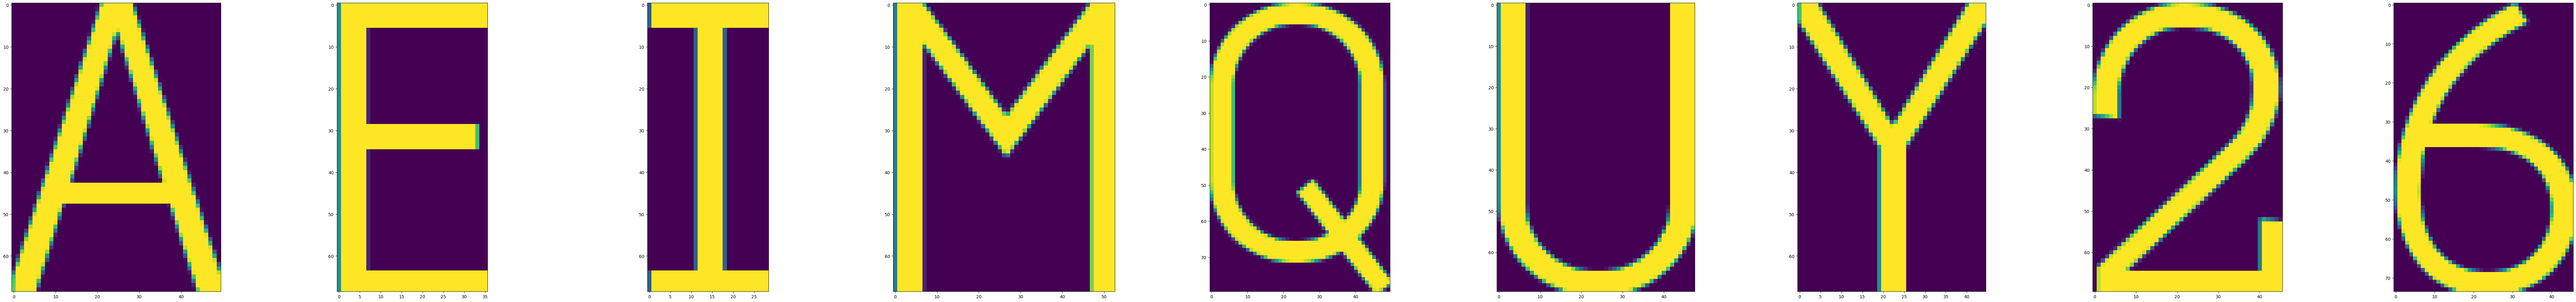

In [8]:
def get_bbox(img):
    """
    Finds a bounding box of a segment.
    """
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return (rmin, cmin), (rmax, cmax)


def gray(im):
    """Fast RGB to grayscale conversion using opencv"""
    if not hasattr(im, 'shape'):
        im = np.array(im)
    if len(im.shape) == 3:
        return cv2.cvtColor(im.copy(), cv2.COLOR_RGB2GRAY)
    else:
        return im

def down(x, scale=2):
    """Hard downsampling. Without additional smoothing, this is really useful for binary arrays."""
    return x[::scale,::scale]

def crop_to_bbox(arr, bbox):
    b = bbox
    return arr[b[0][0]:b[1][0], b[0][1]:b[1][1]]


# def touches_edge(seg, within=1):
#     """
    
#     """
#     edge = np.zeros_like(seg)
#     edge[0:within+1,:] = 1
#     edge[-1-within:,:] = 1
#     edge[:,0:within+1] = 1
#     edge[:,-1-within:] = 1
#     return (edge * seg).any()

def center(x):
    """
    Returns center of mass of a blob x
    """
    M = sk.measure.moments(x,order=1)
    centroid = np.array([M[1, 0] / M[0, 0], M[0, 1] / M[0, 0]])
    return centroid

# def get_bcircle(img):
#     c = center(img).astype(int)
#     rows = np.any(img, axis=1)
#     cols = np.any(img, axis=0)
#     r = int(max(sum(rows),sum(cols))/2)
#     return c,r

def get_bsquare_area(img):
    """
    Returns bounding *square* (not box) area. Useful for distinguishing
    line-line segments from square-like segments (crystals)
    """
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    r = max(sum(rows),sum(cols))
    return r ** 2
def alpha_blend(a,b,alpha = .7,color=(0,204,255),):
    """
    Overlays image array b over image array a, using alpha opacity
    """
    if len(b.shape) == 2:
        b = b[...,np.newaxis]
    blend = (a * alpha + (1 - alpha) * (b* np.array(color).T)).astype('uint8')
    return blend

def blob_distance(b1,b2, sampling = 1):
    """Given two binary blobs, b1, b2, Returns minimum distane (distance, point_a, point_b), 
    where point_X is the nearest point from blob X to blob Y"""
    b1_dist = ndi.distance_transform_edt(~b1,sampling=sampling)
    b1_dist[b2 == 0] = np.inf
    b2_point = np.unravel_index(b1_dist.argmin(), b1_dist.shape)
    
    b2_dist = ndi.distance_transform_edt(~b2,sampling=sampling)
    b2_dist[b1 == 0] = np.inf
    b1_point = np.unravel_index(b2_dist.argmin(), b2_dist.shape)
    # compare_n(b1_dist, b2_dist, b1, b2)
    return np.min(b1_dist[b2]), b1_point, b2_point

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in degrees between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.rad2deg(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

def iou(a,b):
    return (a&b).sum()/(a|b).sum()

def ioa(a,b):
    return (a&b).sum()/(b).sum()


def get_symbols() -> dict:
    """
    Reads all .tff font files in store/fonts directory, draws them on NxN image
    and outputs them in the form of {"Empirical W01 Regular" : {"A":[[0,0,....,0,0]], ... } ... }.
    Is used by custom_ocr detect symbols.
    """
    
    def _get_one_font(font_path = 'store/fonts/LiberationMono-Regular.ttf', ):
        font = ImageFont.truetype(str(font_path), size=100)
        result = {}
        for i,c in enumerate(string.ascii_uppercase + string.digits):
            # Reserve big enough image size
            width, height = (200,200)
            # width, height = font.getsize(c)
            # width = font.getsize(c)
            # print(width)
            # height = font.getlength(c, direction='horizontal')
            image = Image.new("L", (width, height), color=(0,))
            draw = ImageDraw.Draw(image)
            # buffer = 0
            draw.text((40,40,30), c, font=font, fill=(255,))
            image = np.array(image)
            img_bbox = get_bbox(image)
            image = crop_to_bbox(image, img_bbox)
            result[c] = image
        return result
    result = {}
    for font in Path('store/fonts/').glob('*.ttf'):
        result[font.stem] = _get_one_font(font_path = font)
    return result

fonts_symbols = get_symbols()
compare_n(*[s for k,s in list(fonts_symbols['Empirical W01 Regular'].items())[::4] ])

In [6]:
def prefetch(images):
    """
    Given a list of images, this function creates a generating function, 
    which doesn't wait for the main thread to ask it for the new image.
    The generating function will load the image in the background, using a separate thread,
    thus eliminated the waiting time for image loading for the main thread.
    """
    outputs = queue.Queue(maxsize=20)
    inputs = queue.Queue(maxsize=-1)
    STOP = object()
    def worker():
        while True:
            inp = inputs.get()
            if inp is STOP:
                outputs.put(STOP)
                break
            outputs.put((np.array(inp), Path(inp.filename).stem))
            inp.close()
        
    threading.Thread(target=worker, daemon=True).start()
    for image in images:
        inputs.put(image)
    inputs.put(STOP)
    
    def gen():
        while True:
            result = outputs.get()
            if result is STOP:
                break
            yield result
    return gen

# catch_time = CatchTime()


# images = video_to_frames(args.input_video)

# with catch_time.time("Full time"):
#     for i,pil_img in enumerate(tqdm(images[::3], desc='Detecting marker')):
#         with catch_time.time("Load img"):
#             rgb_image = np.array(pil_img)
#         with catch_time.time("Process"):
#             time.sleep(.01)
#         with catch_time.time("Close img"):
#             pil_img.close()
        
# catch_time.plot()

# images = video_to_frames(args.input_video)

# catch_time = CatchTime()
# with catch_time.time("Full time"):
#     for i,rgb_image in enumerate(tqdm(prefetch(images[::3])(), desc='Detecting marker')):
#         with catch_time.time("Process"):
#             time.sleep(.01)

# catch_time.plot()
# # for i parallel_load(images)

def mask_segs_plus(edgeseg, marker: Marker):
    """Discards an entire segment (crystal or otherwise) if
    it covers at least 40% of the marker's oriented bounding box (obb)."""
    if marker.obb is not None:
        obb = marker.obb.astype(bool)
        for seg_id in np.unique(obb * edgeseg):
            if seg_id != 0:
                seg = (edgeseg == seg_id)
                edgeseg[seg] = 0
                if (seg & ~obb).sum() > obb.sum() * .4:
                    warn_once(logging, "MARKER PLACEMENT FILTERED OUT A LARGE SEGMENT (LIKELY A MISPLACED CRYSTAL)")
                # intersect = obb & seg
                # if intersect.any():
                    # edgeseg[seg] = 0
                ## NOTE: More selective filtering won't work, because second number weakly intersects the OBB edge
                # union = obb | seg
                # if union.any():
                #     iou = intersect.sum() / union.sum()
                # else:
                #     iou = 0
                # if iou > 0.
    return edgeseg

def px2micron_ratio(marker):
    """
    Given upright-facing marker's bounding box, calculates the pixel-to-micron ratio. 
    Otherwise returns the default ratio of 2.5
    """
    if marker.bbox is not None:
        x = np.array(marker.bbox)
        x = np.mean(np.abs(x[0] - x[1]) + 1) * 4
        return x/100 # how many pixels in 1 micron
    else:
        logger.warning('MARKER DETECTION FAILED, UNABLE TO OBTAIN ACCURATE PIXEL/MICRON RATIO, DEFAULTING TO 2.5 PX per MICRON.')
        return 2.5
    
def custom_ocr(marker: Marker, fonts_symbols):
    """
    Performs OCR by matching symbols with a font dictionary.
    First symbol is assumed to be within A-Z, and last two are assumed to be from digits 0-9.
    Similarity scores are averaged between all provided font files, with the result
    being a symbol that has a maximum average similarity.
    """
    results = []
    if marker.symbol_seg is None or len(marker.symbol_seg) == 0:
        return []
    for i,to_predict in tqdm(enumerate(marker.symbol_seg)):
        to_predict = to_predict.copy()
        to_predict = sk.transform.rotate(to_predict, marker.angle, 
                                         center=center(to_predict)[::-1], 
                                         order=0)
        to_predict = crop_to_bbox(to_predict, get_bbox(to_predict)) > 0

        for font_name, font_symbols in fonts_symbols.items():
            for symbol_name, symbol in font_symbols.items():
                if (i == 0 and symbol_name in string.ascii_uppercase) or (i > 0 and symbol_name in string.digits):
                    symbol = (sk.transform.resize(symbol, to_predict.shape, order=0) / 255.) > 0
                    # print(symbol.dtype, symbol.max(), symbol.min())
                    # print(to_predict.dtype, to_predict.max(), to_predict.min())
                    metric = ((symbol & to_predict).sum()/(symbol | to_predict).sum())
                    results.append(dict(
                        place=i,
                        font_name=font_name,
                        symbol_name = symbol_name, 
                        symbol = symbol,
                        # similarity = similarity,
                        metric = metric,
                    ))
    results = pd.DataFrame(results)
    # from IPython.display import display
    # display(results)
    preds = []
    for i,to_predict in tqdm(enumerate(marker.symbol_seg)):
        x = results[results.place == i]
        x = x.groupby(['symbol_name'])['metric'].mean()
        x = x / x.sum()
        preds.append( x.nlargest(1).to_dict() )
    return preds

def get_stable_segmentation(pred_seg, contact_area = None, non_contact_area = None):
    """
    Prepares segmentation results for export.

    Assigns a unique ID to each crystal on frame, based on that crystal's XY position. 
    Creates fine-grained crystal contours.
    Caclulates the position of the crystal's center of mass.
    Caclulates four distances for each crystal 
        - pair of distances to nearest contact region and to nearest non-contact one.
        - pair of distances from center of crystal, and edge of crystal.


    pred_seg: Crystal segment candidates
    contact_area: Area that is covered by PVC at this point in time
    non_contact_area: Largest non-pvc-covered segment in frame

    """

    CRYSTAL_ID_SEP_RES = (1/20,1/25) # Rows, cols, 
    pred_seg_stable = np.zeros_like(pred_seg)
    stable_segments = []
    total_area = np.prod(pred_seg.shape)
    for seg_id in np.unique(pred_seg)[1:]:
        seg = pred_seg == seg_id
        centroid = center(seg)
        stable_id = int((centroid[0] / CRYSTAL_ID_SEP_RES[0])//seg.shape[0]), int((centroid[1] / CRYSTAL_ID_SEP_RES[1])//seg.shape[1])
        stable_id = f"{stable_id[0]:02d}-{stable_id[1]:02d}"
        contour = sk.measure.find_contours(seg, level=.5)

        polymer_distance = {}
        is_covered = False
        if non_contact_area is not None and non_contact_area.any():
            polymer_distance['edge_distance'] = dict(
                non_contact=blob_distance(seg, non_contact_area),
                contact=blob_distance(seg, contact_area),
            )
            ## NOTE: For faster processing, center distance is not being calculated, since it isn't being used
            ## Uncomment code below to calculate center distance as well
            # center_blob = np.zeros_like(seg)
            # centroid = np.array(centroid).astype(int)
            # center_blob[centroid[0],centroid[1]] = 1
            # polymer_distance['center_distance'] = dict(
            #     # NOTE:
            #     non_contact=blob_distance(center_blob, non_contact_area),
            #     contact=blob_distance(center_blob, contact_area),
            # )
            ## ... or keep this approximation instead
            # polymer_distance['center_distance'] = polymer_distance['edge_distance']

            is_covered = polymer_distance['edge_distance']['contact'][0] < 5 and polymer_distance['edge_distance']['non_contact'][0] > 0

        stable_segments.append(dict(
                id=stable_id,
                contour=contour,
                center=centroid,
                covered=is_covered, 
                polymer_distance=polymer_distance,
            )
        )
    stable_segments = sorted(stable_segments, key=lambda e:e['id'])
    return stable_segments

## Args

In [7]:
args = argparse.ArgumentParser()
args.add_argument(
    "-i", "--input_video",
    help='Path of input video',
    type=Path,
    default=Path('store/all_videos/000001.mp4')
)
args.add_argument(
    "-o", "--output_dir",
    help='Output directory (it will be deleted first!)',
    type=Path,
    default=Path('store/results/000001')
)
args.add_argument(
    "-lt", "--line_thresh",
    help='Range: [0,1]. Higher values will reject more acute crystals (slim, line-like crystals).',
    type=float,
    default=.15,
)

args.add_argument(
    "-mca", "--min_crystal_area",
    help='(Experimental Feature) Range: [0, +Inf). The segmentation algorithm will reject crystals with surface areas (px^2) less than given number.'
        'IMPORTANT: This value will be interpreted as square microns. However, in case the marker hasn\'t been successfully detected, a pixel-to-micron ratio'
        ' conversion will be impossible and a default ratio will be used',
    type=int,
    default=90,
)

args.add_argument(
    "--debug_plots",
    help='Range [False, True], Create informative debug frames every 100 frame when contact line is not visible, or every 20 frames when it is. Slows down processing speed a little.',
    type=bool,
    default=True,
)

args.add_argument(
    "--clean_ffmpeg_cache",
    help='Range: [False, True], Remove tmp directory that was storing ffmpeg-extracted video frames. Useful in case initial video-to-frames conversion was interrupted.',
    type=bool,
    default=False,
)

args.add_argument(
    "-j","--num_workers",
    help="Number of workers (physical cores) that iterate loops that can be safely parallelized (like generating a visualization video, once all data is available). Each worker requires 0.8GB RAM memory.",
    type=int,
    default=8,
)

# Add more args here...
logger = get_logger()
if 'NB_EXEC_ARGS' in os.environ: # If executed by main.py...
    sys.argv = Path('.nb_args').open('r').read().split() # Args from .nb_args file
    tqdm = partial(tqdm, file=Path('progress.log').open('a')) # Progress to progress.log file
    # Configure logger to write to a file...
    import sys
    import traceback
    import IPython

    def showtraceback(self, *args, **kwargs):
        traceback_lines = traceback.format_exception(*sys.exc_info())
        del traceback_lines[1]
        message = ''.join(traceback_lines)
        # sys.stderr.write(message)
        logger.critical(f"Uncaught exception {message}")
        logger.critical(f"Shutting down")

    import IPython
    IPython.core.interactiveshell.InteractiveShell.showtraceback = showtraceback


args,_ = args.parse_known_args()

if args.output_dir.exists():
    shutil.rmtree(args.output_dir) # Clean output_dir
    
mkdir(args.output_dir)
args.tmp_dir = Path(tempfile.mkdtemp(dir=mkdir('store/tmp')))

tmp_video_frames_dir = mkdir(args.output_dir / 'debug_video_frames')

if args.clean_ffmpeg_cache:
    shutil.rmtree('store/tmp/ffmpeg_cache', ignore_errors=True)

## Main

Found store/all_videos/000001.mp4 cached at store/ffmpeg_cache/072904f79b95873370bada652c1f51d1


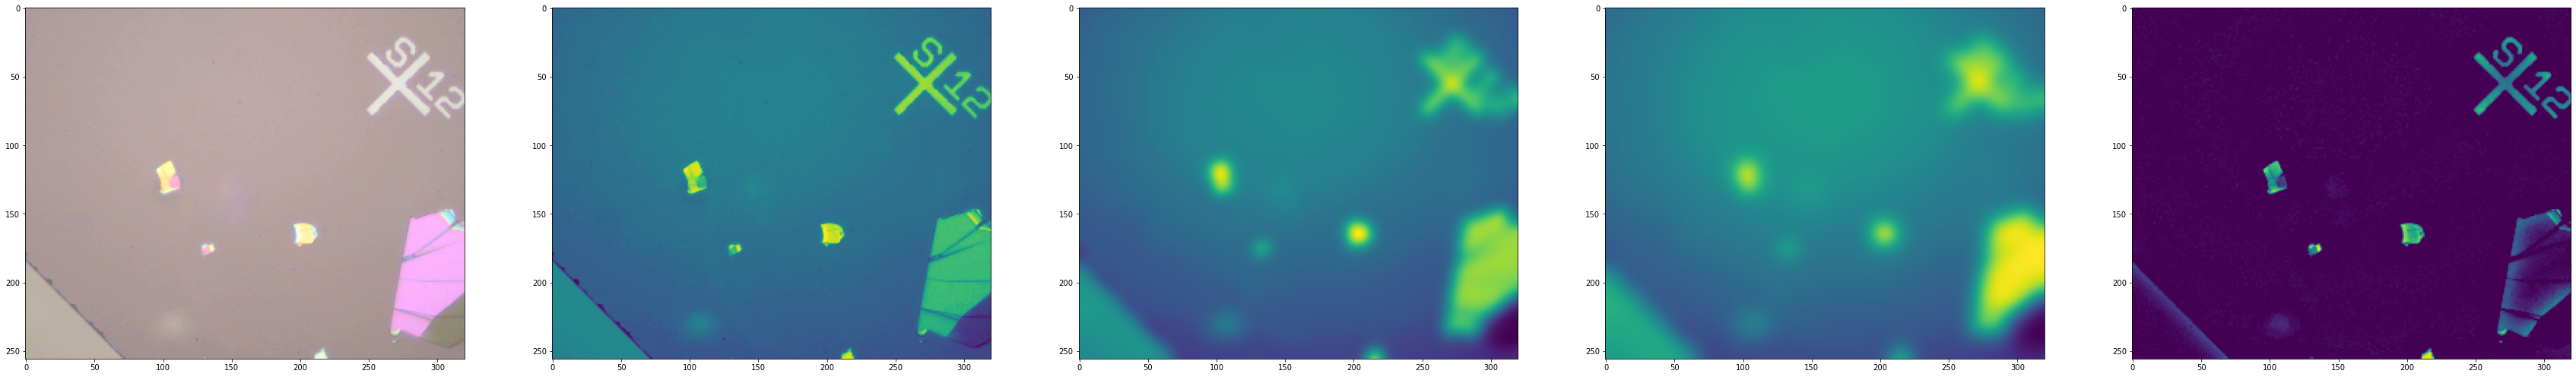

Detecting marker:   0%|          | 0/1 [00:00<?, ?it/s]

THIS IS A MARKER


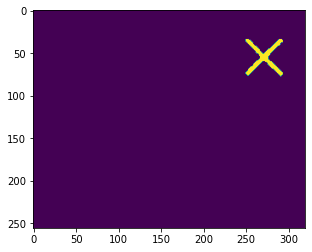

Detecting marker: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


True angle is 44 from positive vertical axis


2it [00:00, 44.89it/s]
2it [00:00, 313.90it/s]


OCR RESULTS S1
Found store/all_videos/000001.mp4 cached at store/ffmpeg_cache/072904f79b95873370bada652c1f51d1


Segmenting all frames:   0%|          | 0/144 [00:00<?, ?it/s]

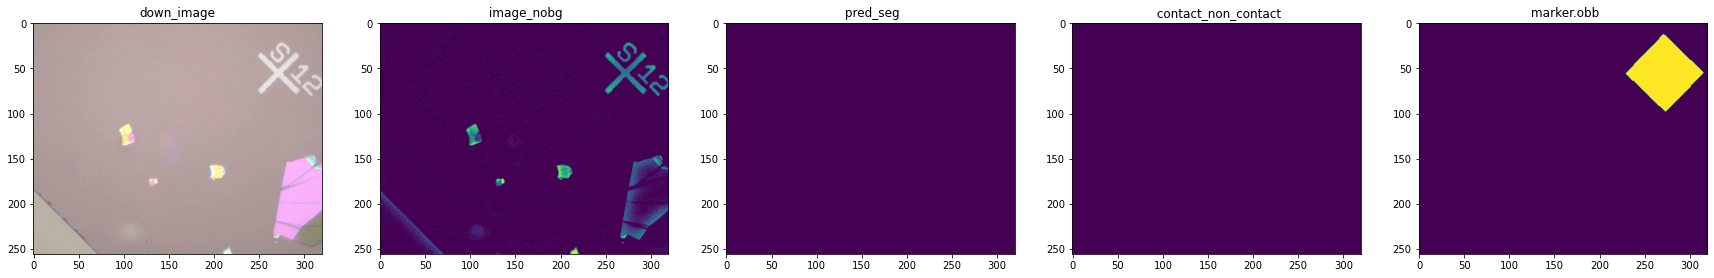

Segmenting all frames: 100%|██████████| 144/144 [00:08<00:00, 17.97it/s]


In [8]:
randrange = list(range(0,16))
random.shuffle(randrange)
catch_time = CatchTime()
bad_vids = [3,7,8,14, 15]
avg_vids = [1,2]
good_vids = [0]
no_marker_no_crystal = [12]
vid_has_lighting_change = [4,6]

# for i in range(16):
#     args.output_dir = mkdir(Path(f'store/results')/f'{i:06d}')
#     args.input_video = Path(f'store/all_videos/{i:06d}.mp4')

for i in [0]:
    debug_plots_dir = mkdir(args.output_dir / 'debug_plots')
    
    shutil.copy(args.input_video, args.output_dir)
    # args.input_video = f'store/all_videos/000007.mp4'
    images = video_to_frames(args.input_video)
    marker = Marker()
    rgb_image = np.array(images[0])
    down_image = down(rgb_image,4)
    image = gray(down_image)
    marker.obb = np.zeros_like(image,'uint8')
    x = sk.filters.gaussian(image, 5)
    bg = sk.restoration.rolling_ball(x, radius=200)
    bg = sk.filters.gaussian(bg, 5) * 255.
    # bg = sk.transform.rescale(bg, 2, order=0, channel_axis=-1, preserve_range=True)
    # background = sk.transform.rescale(background, 2, preserve_range=True, channel_axis=-1)
    # background = background.astype('uint8')
    compare_n(down_image, image, x, bg, np.clip(image - bg, 0, 255))
    
    for i,pil_img in enumerate(tqdm(images[:1], desc='Detecting marker')):
        rgb_image = np.array(pil_img)
        img_id = Path(pil_img.filename).stem
        down_image = down(rgb_image,4)
        image = gray(down_image,)
        edge = sk.feature.canny(image, sigma=0, mode='mirror')
        # edge = filters.gaussian(edge,sigma=1)
        edgeseg = sk.segmentation.watershed(edge, watershed_line=True)
        # edgeseg = ndi.binary_fill_holes(edgeseg - 1)
        edgeseg = sk.measure.label(edgeseg,)
        # compare_n(down_image, edgeseg)
        
        with catch_time.time('Marker detection'):
            for seg_id in np.unique(edgeseg):
                seg = edgeseg == seg_id
                if seg.sum() > 490 and seg.sum() < 810: # Normal range for marker area
                    # print("Good size", seg.sum())
                    # show(seg)
                    seg_center = center(seg)
                    # print(seg_center)
                    cardinal_sim = []
                    for angle in [0,90,180,270]: # TODO: These two loops can be optimized with early stopping
                        seg_r = sk.transform.rotate(seg,angle,
                                                    order=0,
                                                    center=seg_center[::-1],resize=False, preserve_range=True)
                        cardinal_sim.append((seg_r * seg).sum())

                    interm_sim = []
                    for angle in [0+45,90+45,180+45,270+45]:
                        seg_r = sk.transform.rotate(seg,angle,
                                                    order=0,
                                                    center=seg_center[::-1],resize=False, preserve_range=True)
                        interm_sim.append((seg_r * seg).sum())

                    if min(cardinal_sim) > max(interm_sim) * 2:
                        marker.seg = seg.copy().astype('uint8')
                        marker.seg_id = seg_id
                        marker.center = seg_center
                        print("THIS IS A MARKER")
                        show(seg)
                        break
        if marker.seg is not None:
            with catch_time.time('angle finding'):
                marker.center = center(marker.seg)
                b_areas = []
                for angle in range(91):
                    seg_r = sk.transform.rotate(marker.seg,
                                                angle,
                                                order=0,
                                                center=marker.center[::-1],
                                                resize=False, preserve_range=True)
                    b_areas.append(get_bsquare_area(seg_r))

                b_areas = sps.medfilt(b_areas,5)
                angle,_ = sps.find_peaks(b_areas)
                marker.angle = angle[0]
            
            with catch_time.time('symbol finding'):
                marker.bbox = get_bbox(
                            sk.transform.rotate(marker.seg,
                            marker.angle,
                            center=marker.center[::-1],
                            resize=False, 
                            preserve_range=True))
                rr,cc = sk.draw.rectangle(marker.bbox[0],marker.bbox[1])
                marker.obb[rr,cc] = 1
                marker.obb = sk.transform.rotate(marker.obb,
                                                 -marker.angle,
                                                 order=0,
                                                 center=marker.center[::-1],
                                                 resize=False, 
                                                 preserve_range=True)
                marker.symbol_seg = []
                for seg_id in np.unique(edgeseg):
                    if seg_id != 0:
                        seg = edgeseg == seg_id
                        if seg.sum() > 60 and seg.sum() < 200 and (marker.obb * seg).any(): # Normal range for symbols
                            for existing_seg in marker.symbol_seg:
                                a = seg > 0
                                b = existing_seg > 0
                                if (ndi.binary_fill_holes(existing_seg) & a == a).all():
                                    # seg is in existing_seg's hole. Skip it.
                                    break
                            else:
                                # print(seg.sum())
                                marker.symbol_seg.append(seg.astype('uint8'))
                                # show(seg)
                            
            if len(marker.symbol_seg) >= 2:
                with catch_time.time('angle correction'):
                    x = marker.seg + np.array(marker.symbol_seg).any(0)
                    x = sk.transform.rotate(
                                x,
                                marker.angle,
                                order=0,
                                center=marker.center[::-1],
                                resize=False,
                                preserve_range=True,) > 0
                    x = sk.util.img_as_ubyte(x)
                    d = center(x) - marker.center
                    marker.angle += round(angle_between(d, [-1,0])/90) * 90
                    print("True angle is", marker.angle, "from positive vertical axis")
                if abs(marker.angle) > 90:
                    marker.symbol_seg = marker.symbol_seg[::-1]
                
    px2micron = px2micron_ratio(marker)
    
    if marker.seg is not None:
        m_fname = mkdir(args.output_dir/'marker_segments') / f'{args.input_video.stem}_marker_seg.npy'
        np.save(m_fname, marker.seg,True, False)
        
    if marker.obb is not None:
        m_fname = mkdir(args.output_dir/'marker_segments') / f'{args.input_video.stem}_marker_obb.npy'
        np.save(m_fname, marker.obb,True, False)
    
    if marker.symbol_seg is not None and len(marker.symbol_seg) > 0:
        for i,ms in enumerate(marker.symbol_seg):
            m_fname = mkdir(args.output_dir/'marker_segments') / f'{args.input_video.stem}_marker_symbol_seg.npy'
            np.save(m_fname, ms, True, False)
            
    if marker.symbol_seg is not None and len(marker.symbol_seg) > 0:
        marker.text = ''.join([list(s)[0] for s in custom_ocr(marker, fonts_symbols)])
    else:
        marker.text = 'NOSYMBL'
    print("OCR RESULTS", marker.text)
    images = video_to_frames(args.input_video)

    pil_img = images[0]
    rgb_image = np.array(pil_img).copy()
    down_image = down(rgb_image,4)

    mean_seg = np.zeros(down_image.shape[:2], dtype='float32')
    pred_seg = np.zeros(down_image.shape[:2], dtype='uint8')
    # mean_debris = np.zeros(down_image.shape[:2], dtype='float32')
    contact_area = np.zeros(down_image.shape[:2], dtype='bool')
    num_contact_area_segments = []
    
    borders = np.ones(down_image.shape[:2], dtype='bool')
    borders[1:-1, 1:-1] = 0
    total_area = np.prod(down_image.shape)
    for i, (rgb_image, img_id) in enumerate(tqdm(prefetch(images[::3])(), 
                                                 total=len(images[::3]), 
                                                 desc='Segmenting all frames')):
    # for i, pil_img in enumerate(tqdm(images[::3], desc='Segmenting all frames')):
    #     with catch_time.time('PIL to np'):
    #         rgb_image = np.array(pil_img)
    #         img_id = Path(pil_img.filename).stem
    #         pil_img.close()
        with catch_time.time('Down, gray, nobg'):
            down_image = down(rgb_image,4)
            image = gray(down_image)
            # image = sk.filters.gaussian(image, 3/2, preserve_range=True)
            image_nobg = np.clip(image - bg,0,255).astype('uint8')
        with catch_time.time('Canny'):
            edge = sk.feature.canny(sk.transform.rescale(image, scale=1/2, order=0), sigma=0.0, mode='nearest')
            edge = sk.transform.resize(edge, image.shape, order=0)
        with catch_time.time('BDI'):
            edge_d = ndi.binary_dilation(edge)
        with catch_time.time('Gaussian'):
            edge_d = sk.filters.gaussian(edge_d,sigma=1)
        with catch_time.time('Edgeseg'):
            m = np.zeros_like(edge_d)
            # m[colorseg == 0] = 1
            # m[colorseg > 0] = 2
            m[edge_d < .1] = 1
            m[edge_d >= .1] = 2
            # compare(edge, m)
            edgeseg = sk.segmentation.watershed(edge, markers=m, watershed_line=True)
            edgeseg = ndi.binary_fill_holes(edgeseg - 1)
            edgeseg = sk.measure.label(edgeseg,)

        if contact_area.sum() > total_area * .1: ## CONTACT AREA INBOUND, FREEZE CRYSTAL MEMORY
            args.segment_memory = .995

        if contact_area.sum() < total_area * .1: ## CONTACT AREA NO LONGER HERE, UNFREEZE MEMORY, ALLOW RAPID DECAY
            args.segment_memory = .95
        
        # This should be done after the line is done
        with catch_time.time('Crystal size-shape filter'):
            edgeseg = sk.morphology.remove_small_objects(edgeseg, args.min_crystal_area * px2micron)
            crystal_candidates = np.zeros_like(edgeseg, 'bool')
            for seg_id in np.unique(edgeseg):
                if seg_id != 0:
                    seg = edgeseg == seg_id
                    area = seg.sum()
                    bsq_area = get_bsquare_area(seg) # Rowmin, Rowmax, Colmin, Colmax
                    ratio = area / bsq_area
                    if ratio <= args.line_thresh:
                        pass
                    else:
                        crystal_candidates |= seg
            crystal_candidates = sk.morphology.binary_erosion(crystal_candidates)
            # mean_seg = mean_seg * args.segment_memory + (1 - args.segment_memory) * 0.0
            # mean_seg[crystal_candidates] = mean_seg[crystal_candidates] * args.segment_memory + (1 - args.segment_memory) * 1.0
            mean_seg = mean_seg * args.segment_memory + (1 - args.segment_memory) * crystal_candidates
            pred_seg = sk.measure.label(mean_seg > .1)
                
        with catch_time.time('Contact area'):
            contact_area[:] = image_nobg > 7
            contact_area, num_contact_area_segment = sk.measure.label(contact_area,return_num=True)

            if num_contact_area_segment > 500: ## THERE HAS BEEN A BG SHIFT!
                logging.warning('ANOMALOUS SHIFT IN SCENE LIGHTING DETECTED! RECALCULATING BACKGROUND...')
                x = sk.filters.gaussian(image, 5)
                bg = sk.restoration.rolling_ball(x, radius=200)
                bg = sk.filters.gaussian(bg, 5) * 255.
                image_nobg = np.clip(image - bg, 0, 255).astype('uint8')
                contact_area[:] = image_nobg > 7
                contact_area, num_contact_area_segment = sk.measure.label(contact_area,return_num=True)

            sk.morphology.remove_small_objects(contact_area, 2000, out=contact_area)
            contact_area = contact_area > 0
            sk.morphology.binary_closing(contact_area, out=contact_area)
            sk.morphology.remove_small_holes(contact_area, 2000, out=contact_area)
            # contact_area[marker.obb>0] = 0

            pred_seg = mask_segs_plus(pred_seg, marker)
            # contact_perim = sk.measure.perimeter_crofton(contact_area)

            non_contact_area = None
            pvc_contour = None
            if contact_area.sum() > total_area * .03:
                free_areas = sk.measure.label(~contact_area)
                x = np.bincount(free_areas.ravel())
                if len(x) > 1:
                    free_area = free_areas == (np.argmax(x[1:]) + 1)
                    if free_area.sum() > total_area * .05:
                        non_contact_area = free_area
                        pvc_contour = max(sk.measure.find_contours(non_contact_area & ~borders),key=len)

            for seg_id in np.unique(pred_seg):
                if seg_id != 0:
                    seg = pred_seg == seg_id
                    if (seg * borders).any():
                        pred_seg[seg] = 0

        # is_covered = np.zeros_like(pred_seg)
                    
        with catch_time.time('Stable seg'):
            stable_segments = get_stable_segmentation(pred_seg, contact_area, non_contact_area)
        
        with catch_time.time('Debug AVG'):
            if args.debug_plots and i % 100 == 0 or ((i % 20 == 0) and contact_area.sum() > total_area * .2):
                with catch_time.time('Debug PEAK'):
                    # print("PERIM/AREA", contact_perim / (contact_area.sum() + .1), contact_perim ** 2 / (contact_area.sum() + .1),
                    #           contact_perim, contact_area.sum()) # 0.21 bad, 0.12 good
                    # print("MEAN IMAGENOBG", np.mean(image_nobg), contact_perim / total_area, num_contact_area_segment)
                    contact_non_contact = contact_area + (non_contact_area if non_contact_area is not None else 0) * 2
                    compare_n(down_image, image_nobg, pred_seg, contact_non_contact, marker.obb, 
                              title="down_image, image_nobg, pred_seg, contact_non_contact, marker.obb,".split(','),
                              figsize=6, show=False)
                    plt.savefig(debug_plots_dir / f'{args.input_video.stem}_{i:06d}_test.jpeg', 
                        # quality=80
                        )
                    if i % 40 == 0:
                        plt.show()
                    plt.close()
                    
        with catch_time.time("File dump"):
            ca_fname = mkdir(args.output_dir/'contact_area') / f'{args.input_video.stem}_{i:06d}.npy'
            np.save(ca_fname, contact_area, True, False)

            Path(args.output_dir / 'results.json').open('a').write(
                json.dumps(
                    dict(
                        frame_id = img_id,
                        marker = dict(
                            text = marker.text,
                            angle = marker.angle,
                            bbox = marker.bbox,
                        ),
                        polymer = dict(
                            filename = str(ca_fname),
                            contour = pvc_contour,
                        ),
                        crystals = stable_segments,
                    ),
                    cls=NumpyEncoder
                ) + '\n',
            )


total 18M
 16M 000001.mp4    4,0K debug_plots	    4,0K marker_segments
4,0K contact_area  4,0K debug_video_frames  1,7M results.json
total 60K
4,0K 000000  4,0K 000004  4,0K 000007  4,0K 000010  4,0K 000013
4,0K 000001  4,0K 000005  4,0K 000008  4,0K 000011  4,0K 000014
4,0K 000003  4,0K 000006  4,0K 000009  4,0K 000012  4,0K 000016


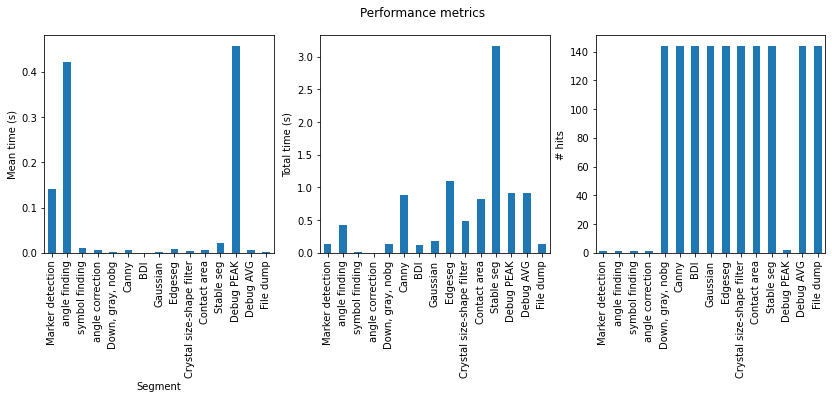

In [9]:
catch_time.plot()
!ls -hs {args.output_dir}
!ls -hs store/results

In [21]:
PALETTE = argparse.Namespace(
    CONTACT_MASK = None,
    PVC_CONTOUR_MASK = (74,246,38),
    
    NON_CONTACT_DISTANCE_MASK = (74,246,38),
    CONTACT_DISTANCE_MASK = (74,246,38),#(255,0,0),
    
    MARKER_SEG_CONTOUR = (74,246,38),
    CRYSTAL_MASK = (74,246,38),
    TEXT_COLOR_COVERED = (0,0,0),
    TEXT_COLOR_NON_COVERED = (255, 255, 255),
)

for output_dir in [args.output_dir]:
    marker = Marker()
    catch_time = CatchTime()
    # marker.symbol_seg = [
    #     np_load_if_exists( output_dir/'marker_segments' / f'{args.input_video.stem}_marker_symbol_seg_{i}.npy')
    #     for i in range(3)
    # ]
    # marker.symbol_seg = [s for s in marker.symbol_seg if s is not None]
    # if len(marker.symbol_seg) == 0:
    #     marker.symbol_seg = None

    marker.seg = np_load_if_exists( output_dir / 'marker_segments' / f'{args.input_video.stem}_marker_seg.npy' )
    marker.obb = np_load_if_exists( output_dir / 'marker_segments' / f'{args.input_video.stem}_marker_obb.npy' )            

    if marker.seg is not None:
        marker.seg = sk.util.img_as_ubyte(sk.transform.rescale(marker.seg, 4, order=0,))
    if marker.obb is not None:
        marker.obb = sk.util.img_as_ubyte(sk.transform.rescale(marker.obb, 4, order=0,))

    for line in (output_dir / 'results.json').open('r'):
        data = json.loads(line)['marker']
        break
    marker.angle = data['angle']
    marker.text = data['text']
    if marker.text is None:
        marker.text = 'NOTXT'

    font = ImageFont.truetype(str('store/fonts/Empirical W01 Regular.ttf'), size=30)

    images = video_to_frames(args.input_video)
    seg = [json.loads(line) 
        for line in (output_dir / 'results.json').open('r')]
    seg = {e.pop('frame_id'): e for e in seg}
    
    import gc
    
    # def process_frame(frame_i,image, frame_id):
    for frame_i,image in enumerate(tqdm(images[::3], "Creating video frames")):
        frame_id = Path(image.filename).stem
        catch_time = CatchTime()
        img_shape = np.array(image).shape
        marker_mask = np.zeros(img_shape[:2],'uint8')
        crystal_mask = np.zeros(img_shape[:2],'uint8')
        mask_id_to_name = {}
        rgb = np.array(image)
        image.close()

        # HACK: The segmentations are downscaled by 4, gotta make them independent of that! This is temp fix for this.
        # show(marker_mask)
        # print(marker_mask.dtype)
        # rgb = sk.color.label2rgb(mask, rgb, bg_color=None)
        with catch_time.time("crystal"):
            if frame_id in seg:
                data = seg[frame_id]
                crystal_mask = np.zeros(rgb.shape[:2], 'uint8')
                contact_distance_mask = np.zeros(rgb.shape[:2], 'uint8')
                non_contact_distance_mask = np.zeros(rgb.shape[:2], 'uint8')
                mask_id_to_name = {}
                mask_id_to_coverage = defaultdict(lambda:False)
                for i,crystal in enumerate(data['crystals']):
                    for contour in crystal['contour']:
                        # HACK: The segmentations are downscaled by 4, gotta make them independent of that! This is temp fix for this.
                        contour = np.array(contour) * 4
                        for x in [10,5,0]:
                            try:
                                contour_down = sk.measure.approximate_polygon(contour,x)
                                rr,cc = sk.draw.polygon_perimeter(contour_down[:,0], contour_down[:,1],shape=crystal_mask.shape)
                                break
                            except IndexError:
                                pass        
                        crystal_mask[rr,cc] = i + 2

                    dist = None
                    if len(crystal['polymer_distance']) > 0:
                        nc_dist, a, b = crystal['polymer_distance']['edge_distance']['non_contact']
                        # c = np.array(crystal['center']) * 4
                        nc_dist *= 4
                        a = np.array(a) * 4
                        b = np.array(b) * 4
                        # a,b = np.array([a,b]) * 4
                        rr,cc = sk.draw.line(*a,*b)
                        non_contact_distance_mask[rr,cc] = i + 2

                        c_dist, a, b = crystal['polymer_distance']['edge_distance']['contact']
                        # c = np.array(crystal['center']) * 4
                        c_dist *= 4
                        a = np.array(a) * 4
                        b = np.array(b) * 4
                        # a,b = np.array([a,b]) * 4
                        rr,cc = sk.draw.line(*a,*b)
                        contact_distance_mask[rr,cc] = i + 2
                        dist = max(c_dist, nc_dist)
                    mask_id_to_coverage[i + 2] = crystal['covered']
                    mask_id_to_name[i + 2] = (crystal['id'], dist)
                non_contact_distance_mask = sk.morphology.dilation(non_contact_distance_mask)
                contact_distance_mask = sk.morphology.dilation(contact_distance_mask)
        with catch_time.time('pvc contour'):
            pvc_contour_mask = np.zeros(rgb.shape[:2], 'uint8')
            x = data['polymer']['contour']
            if x is not None:
                x = np.array(x) * 4
                rr,cc = sk.draw.polygon_perimeter(x[:,0],x[:,1])
                pvc_contour_mask[rr,cc] = 1
                pvc_contour_mask = sk.morphology.dilation(pvc_contour_mask)

        with catch_time.time("cmask"):
                contact_mask = np.load(data['polymer']['filename']).astype('uint8')
                contact_mask = sk.transform.rescale(contact_mask,4,order=0, preserve_range=True,)
                contact_mask = contact_mask > 0      
                crystal_mask = sk.morphology.dilation(crystal_mask,)

        with catch_time.time("Save"):
            with catch_time.time("Draw"):

                if PALETTE.CONTACT_MASK is not None:
                    rgb = alpha_blend(rgb, contact_mask, .7, PALETTE.CONTACT_MASK)

                rgb[pvc_contour_mask>0] = PALETTE.PVC_CONTOUR_MASK #(255, 95, 31)

                rgb[non_contact_distance_mask > 0] = PALETTE.NON_CONTACT_DISTANCE_MASK #(0,255,0)
                rgb[contact_distance_mask > 0] = PALETTE.CONTACT_DISTANCE_MASK #(255,0,0)

                if marker.seg is not None:
                    cont = sk.measure.find_contours(marker.seg)[0]
                    cont = sk.measure.approximate_polygon(cont, 4)
                    rr,cc = sk.draw.polygon_perimeter(cont[:,0], cont[:,1])
                    marker_seg_contour = np.zeros(rgb.shape[:2], 'uint8')
                    marker_seg_contour[rr,cc] = 1
                    marker_seg_contour = sk.morphology.binary_dilation(marker_seg_contour)
                    rgb[marker_seg_contour > 0] = PALETTE.MARKER_SEG_CONTOUR

                    # if marker.symbol_seg is not None:
                    #     for sym in marker.symbol_seg:
                    #         cont = sk.measure.find_contours(sym > 0)[0]
                    #         rr,cc = sk.draw.polygon_perimeter(cont[:,0], cont[:,1])
                    #         rgb[rr,cc] = PALETTE.MARKER_SEG_CONTOUR

                rgb[crystal_mask > 0] = PALETTE.CRYSTAL_MASK # Terminal green
                # rgb[pvc_mask > 0] = (0, 204, 255) # Sky-blue
            with catch_time.time("Save - text add"):
                for c_mask_id, (cid,cdist) in mask_id_to_name.items():
                    if cdist is None:
                        cdist = 'NA'
                    else:
                        cdist = f'{int(int(cdist) * float(px2micron)):.1f}μm'

                    if mask_id_to_coverage[c_mask_id]:
                        text_color = (*PALETTE.TEXT_COLOR_COVERED, 128)
                    else:
                        text_color = (*PALETTE.TEXT_COLOR_NON_COVERED, 128)
                    rgb = write_text(f"ID{cid}\n{cdist}", 
                                     center(crystal_mask == c_mask_id) - 50, 
                                     rgb, font=font, fill=text_color)

                if marker.seg is not None and marker.seg.any():
                    rgb = write_text(marker.text+"@"+str(marker.angle)+'°', 
                                        center(marker.seg), 
                                        rgb, font=font)
            with catch_time.time("Save - image dump"):
                sk.io.imsave(
                    mkdir(output_dir / 'tmp_frames') / f'{frame_id}.jpg',
                    rgb,
                    check_contrast=False,
                    quality=80,
                )
        # if frame_i % 100 == 0:
        #     im = sk.io.imread(mkdir(output_dir / 'tmp_frames') / f'{frame_id}.jpg')
        #     compare_n(im, rgb, figsize=3)
    # def chunks(lst, n):
    #     """Yield successive n-sized chunks from lst."""
    #     for i in range(0, len(lst), n):
    #         yield lst[i:i + n]

    # for chunk in tqdm(list(chunks(images[::3], 200, )), "Processing image batches"):
    #     Parallel(args.num_workers, backend="loky")(
    #         delayed(process_frame)(frame_i, 
    #                                image, 
    #                                Path(image.filename).stem) 
    #         for frame_i,image in enumerate(tqdm(chunk, "Creating video frames")))
        # gc.collect()
    pattern_to_video(
        mkdir(output_dir / 'tmp_frames') / '*.jpg',
        args.output_dir / 'visuals.mp4'
    )

Found store/all_videos/000001.mp4 cached at store/ffmpeg_cache/072904f79b95873370bada652c1f51d1


Creating video frames: 100%|██████████| 144/144 [00:20<00:00,  7.20it/s]
